# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction-to-Outlier-Mitigation" data-toc-modified-id="Introduction-to-Outlier-Mitigation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction to Outlier Mitigation</a></div><div class="lev2 toc-item"><a href="#Making-the-data" data-toc-modified-id="Making-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Making the data</a></div><div class="lev1 toc-item"><a href="#Mitigating-outliers" data-toc-modified-id="Mitigating-outliers-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Mitigating outliers</a></div><div class="lev2 toc-item"><a href="#Spearman-Regression" data-toc-modified-id="Spearman-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Spearman Regression</a></div>

# Introduction to Outlier Mitigation

Welcome to our brief tutorial on the Bayesian theorem and why to use it to perform linear regressions. First, we will provide a motivational example with synthetic data, showing how usual least-squares would do, and then we will introduce Bayes to perform a robust regression.

In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as scipy

from matplotlib import rc

# set to use tex, but make sure it is sans-serif fonts only
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# bayes and mcmc
import pymc3 as pm
import theano

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

## Making the data

First, we will make some data for us to use. 

I will draw 30 points evenly (**not randomly**) from 0 to 10.

In [4]:
x = np.linspace(0, 10, 30)


We will also need some data to plot on the Y-axis. I will draw 30 points between 0 to 10 and I will add just a little bit of noise to most of them. We will replace a random 3 points with outliers

In [86]:
y = np.linspace(0, 10, 30)
y = y + np.random.normal(0, 0.5, len(y))
y[np.random.randint(0, 30, 3)] = np.random.normal(50, 5, 3)

Let's take a look at our data:

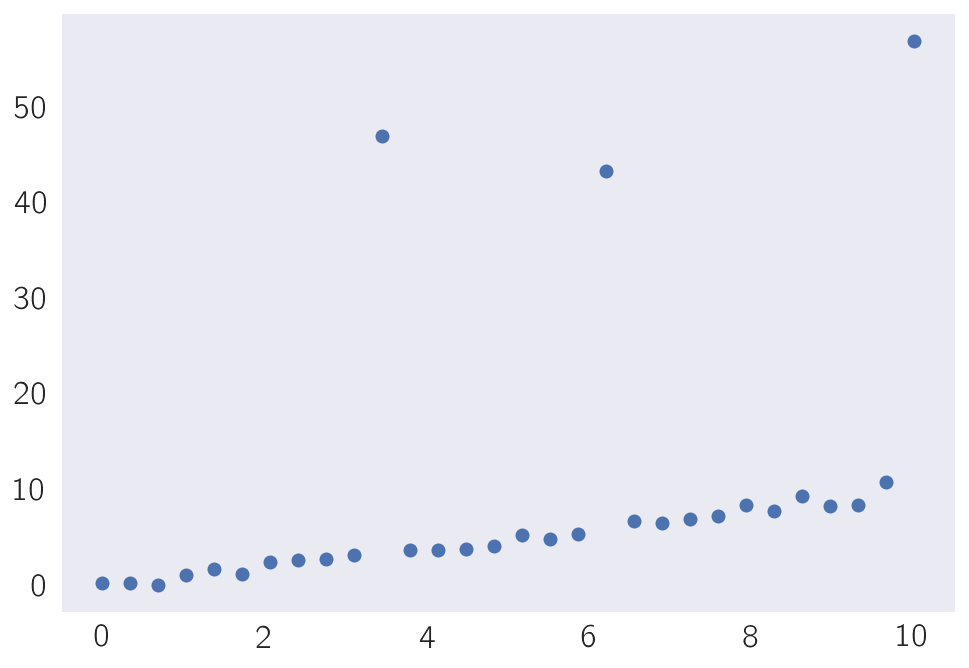

In [87]:
plt.plot(x, y, 'o')

Our data looks pretty good. and we might think that we can calculate a line of best fit. I will use the least-squares algorithm, which is how most lines of best fit are calculated.

In [88]:
def line(x, a, b):
    """The line of best fit."""
    # unpack the parameters:
    y = a + b*x
    
    return y

Perform the optimization

In [89]:
popt, pcov = scipy.optimize.curve_fit(line, x, y)

# unpack the parameters of the line of best fit:
a, b = popt

Let's see the fit:

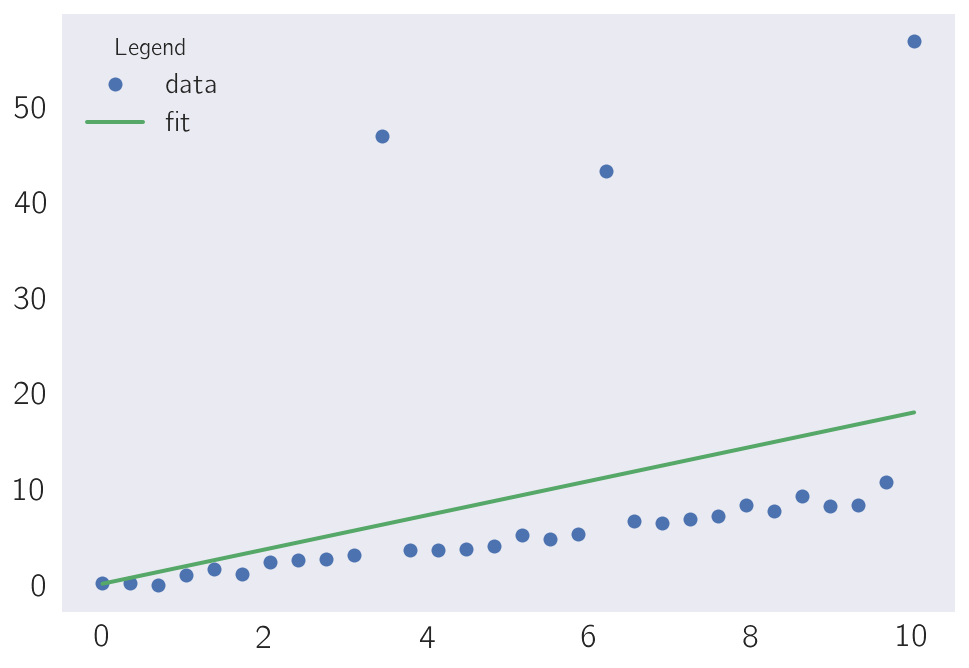

In [90]:
plt.plot(x, y, 'o', label='data')
plt.plot(x, line(x, a, b), label='fit')
plt.legend(title='Legend')

Clearly the fit is not very good. Our eyes can see a better trendline, if only we could ignore the outliers. 

# Mitigating outliers

One common approach towards mitigating outliers is to rank the points. Let's see what happens when we do this.

In [134]:
x_ranked = scipy.stats.rankdata(x)
y_ranked = scipy.stats.rankdata(y)

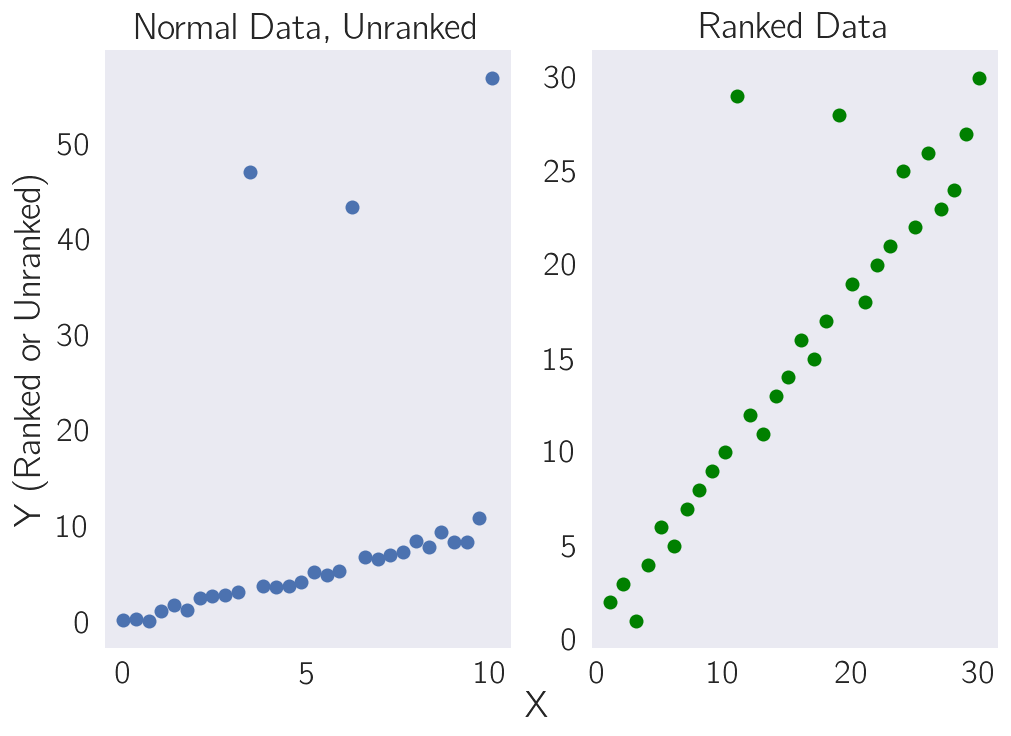

In [135]:
fig, ax = plt.subplots(ncols=2, sharey=False)

ax[0].plot(x, y, 'o')
ax[0].set_title('Normal Data, Unranked')
ax[1].plot(x_ranked, y_ranked, 'go')
ax[1].set_title('Ranked Data')

ax[0].set_ylabel('Y (Ranked or Unranked)')
fig.text(0.5, 0.04, 'X', ha='center', size=18)


## Spearman Regression

Clearly ranking the data mitigates the outliers. This is because rank-transformations are insensitive to the distance from the outliers to the mean trend. They don't care how far away the outliers are, they just care about what their rank order is, and the rank order has to have a more compressed space than the unranked points. In this case, the points can vary from 0 to 60 along the y-axis, but the ranked y-axis can only vary from 0 to 30. Effectively, the distance from the main trend to the outliers is cut in half for this example. 

Let's go ahead and find the line of best fit for the ranked data and plot it. Doing this is called a **Spearman regression**

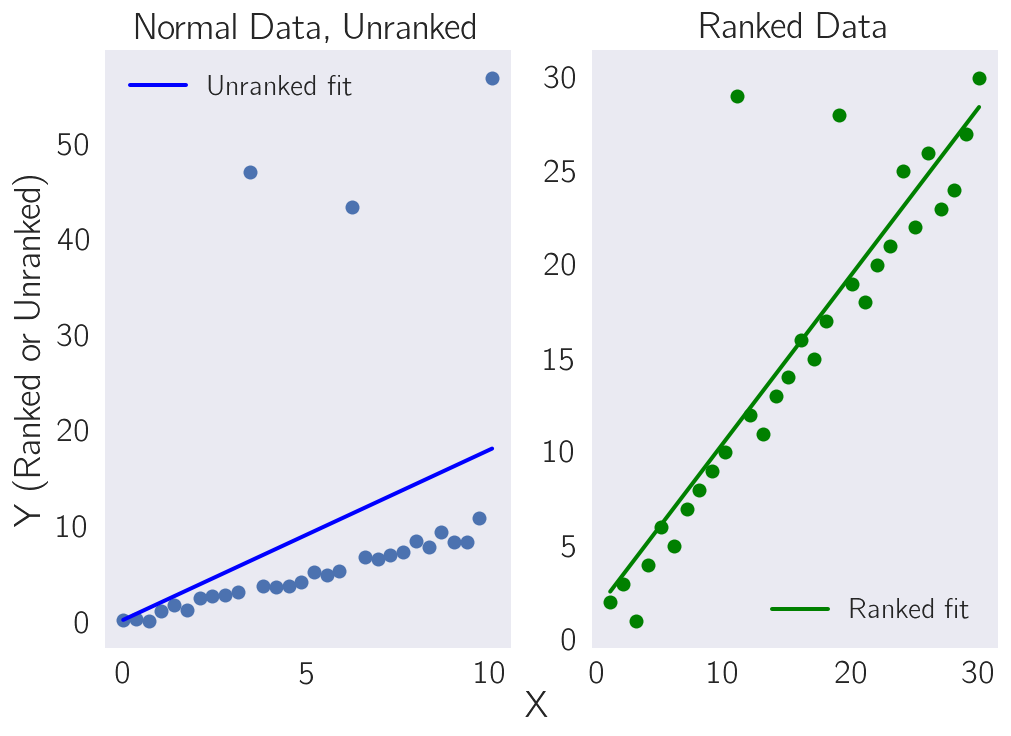

In [146]:
popt, pcov = scipy.optimize.curve_fit(line, x_ranked, y_ranked)
# unpack the parameters of the line of best fit:
arank, brank = popt

# plot
fig, ax = plt.subplots(ncols=2, sharey=False)

ax[0].plot(x, y, 'o')
ax[0].plot(x, line(x, a, b), 'b', label='Unranked fit')
ax[0].legend()
ax[0].set_title('Normal Data, Unranked')
ax[1].plot(x_ranked, y_ranked, 'go')
ax[1].plot(x_ranked, line(x_ranked, arank, brank), 'g', label='Ranked fit')
ax[1].legend()
ax[1].set_title('Ranked Data')

ax[0].set_ylabel('Y (Ranked or Unranked)')
fig.text(0.5, 0.04, 'X', ha='center', size=18)

Great! The spearman correlation can accurately tell us about the line of best fit in the realm of ranked data! 

RNA-seq data is often plagued by terrible outliers that are very far from the mean effect magnitude. For this reason, we often rank-transform the beta values to get a better estimate of the true slope of points.